In [1]:
# Import the research library 
from benchmarklib import BenchmarkDatabase, CompileType

from clique import CliqueProblem, CliqueTrial
import matplotlib.pyplot as plt

In [2]:
# Load Qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_cloud", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")

In [3]:
# update db
import asyncio

db = BenchmarkDatabase("Clique.db", CliqueProblem, CliqueTrial)
#await db.update_all_pending_results(service)

## View Single Trial Results

In [17]:
trial_id = 3
trial = db.get_trial(trial_id=trial_id)
problem = db.get_problem_instance(instance_id=trial.instance_id)
num_vars = problem.nodes
compile_type = trial.compile_type
grover_iters = trial.trial_params['grover_iterations']
clique_size = trial.trial_params['clique_size']
print(f'{problem.clique_counts[clique_size]} Cliques')
print(f'Compile Type: {compile_type}')
print(f'{num_vars} Inputs')
print(f'Searching for size {clique_size} clique')
print(f'{grover_iters} Grover Iterations')
print(f'Expected Success Rate {db.calculate_trial_expected_success_rate(trial)}%')
print(f'Success Rate {db.calculate_trial_success_rate(trial)}%')

1 Cliques
Compile Type: CompileType.CLASSICAL_FUNCTION
3 Inputs
Searching for size 2 clique
1 Grover Iterations
Expected Success Rate 0.7812500000000001%
Success Rate 0.168%


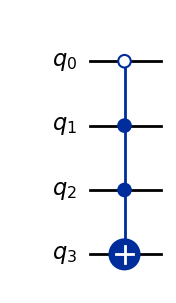

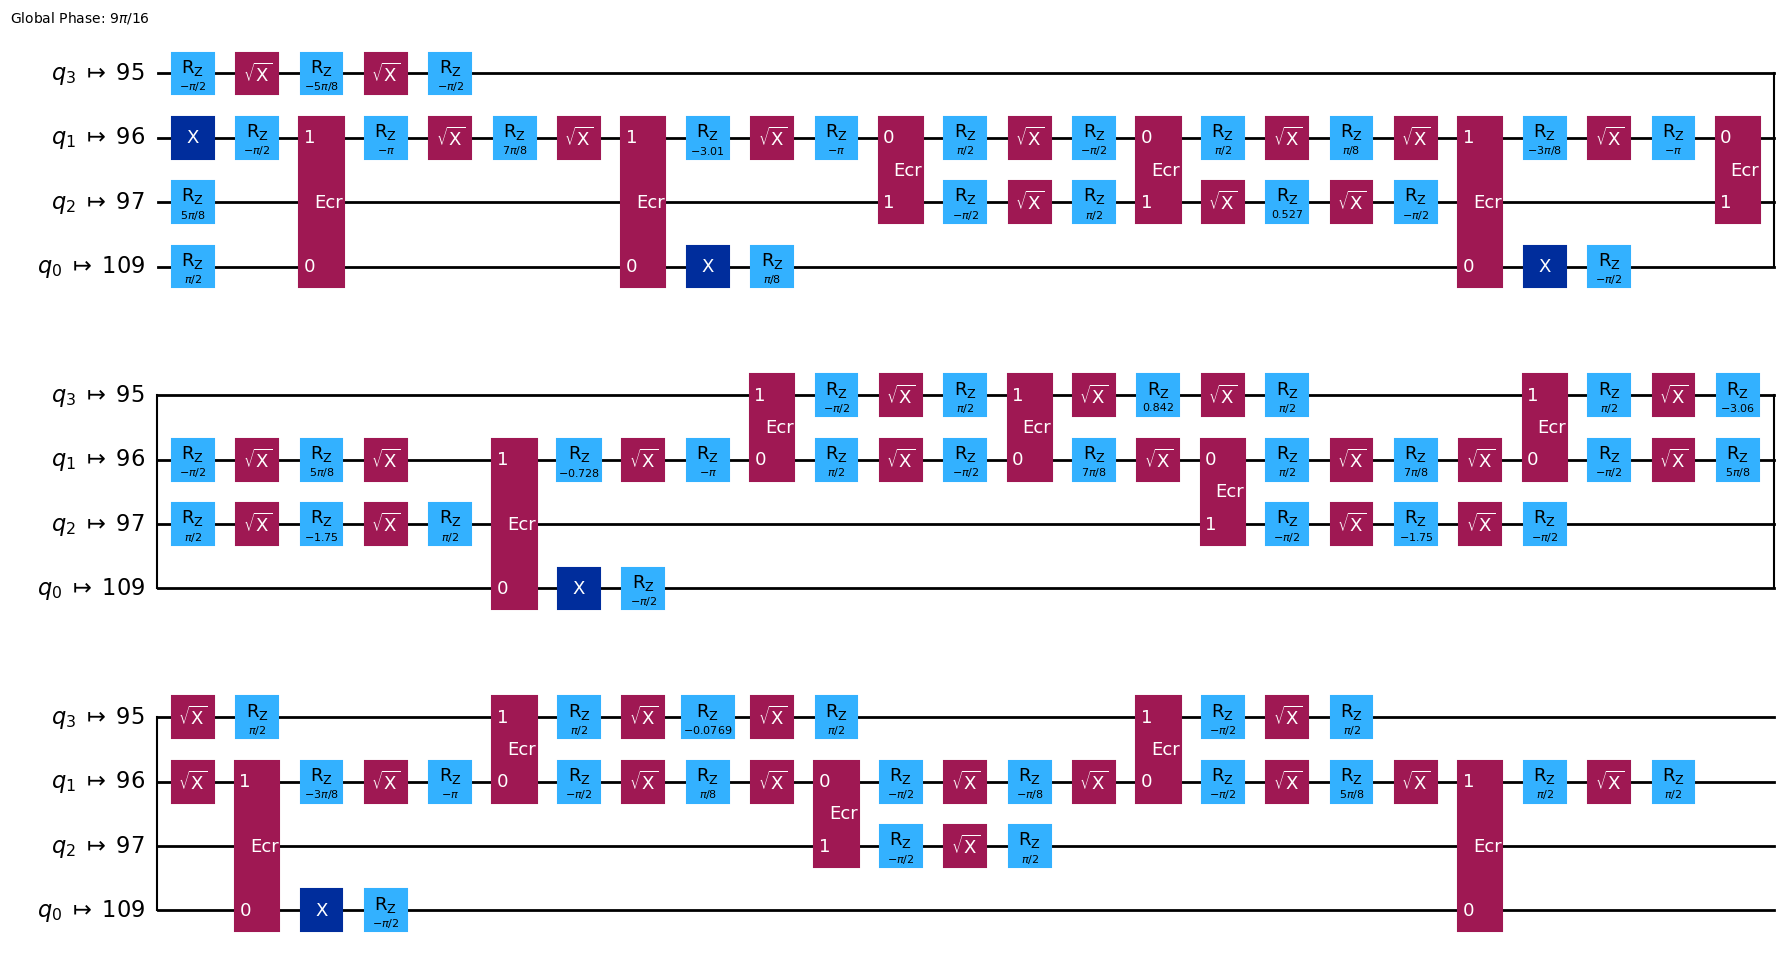

In [18]:
from IPython.display import display # Import the display function
import qiskit

oracle = problem.oracle(compile_type=compile_type, clique_size=clique_size)

rpi_qc = qiskit.transpile(oracle, backend=backend, optimization_level=3)
display(oracle.draw('mpl'))
display(rpi_qc.draw('mpl'))

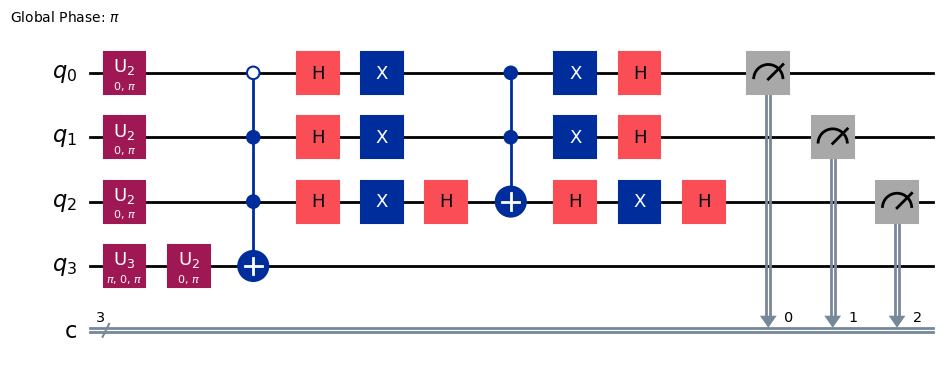

In [19]:
import qiskit
from qiskit.circuit.library import grover_operator
from qiskit_aer import AerSimulator

def build_grover_circuit(oracle: qiskit.QuantumCircuit, num_vars: int, grover_iterations: int) -> qiskit.QuantumCircuit:
        # Determine circuit mode
        #uf_mode = oracle.num_qubits == num_vars + 1

        # Build Grover operator
        grover_op = grover_operator(oracle, reflection_qubits=range(num_vars))

        # Create search circuit
        search_circuit = qiskit.QuantumCircuit(oracle.num_qubits, num_vars)

        # Initialize ancilla for Uf mode
        #if uf_mode:
        # set the target qubit to 1
        search_circuit.x(num_vars)
        # hadamard all qubits
        search_circuit.h(range(num_vars + 1))

        # Apply Grover operator
        if grover_iterations > 0:
            search_circuit.compose(grover_op.power(grover_iterations), inplace=True)

        # Measure
        search_circuit.measure(range(num_vars), range(num_vars))

        return search_circuit

grover = build_grover_circuit(oracle, num_vars, grover_iters)
grover = grover.decompose()

display(grover.draw('mpl'))

In [20]:
from typing import Optional, Dict

def run_simulation(circuit: qiskit.QuantumCircuit) -> Optional[Dict[str, int]]:
    simulator = AerSimulator()
    
    try:
        # Transpile for simulator
        qc = qiskit.transpile(
            circuit,
            simulator,
            optimization_level=3,
        )

        # Run simulation
        result = simulator.run(qc, shots=10**4).result()
        counts = result.get_counts()

        print(f"Simulation completed: {len(counts)} unique outcomes")
        return counts

    except Exception as e:
        print(f"Simulation failed: {e}")
        return None

sim_counts = run_simulation(circuit=grover)

Simulation completed: 8 unique outcomes


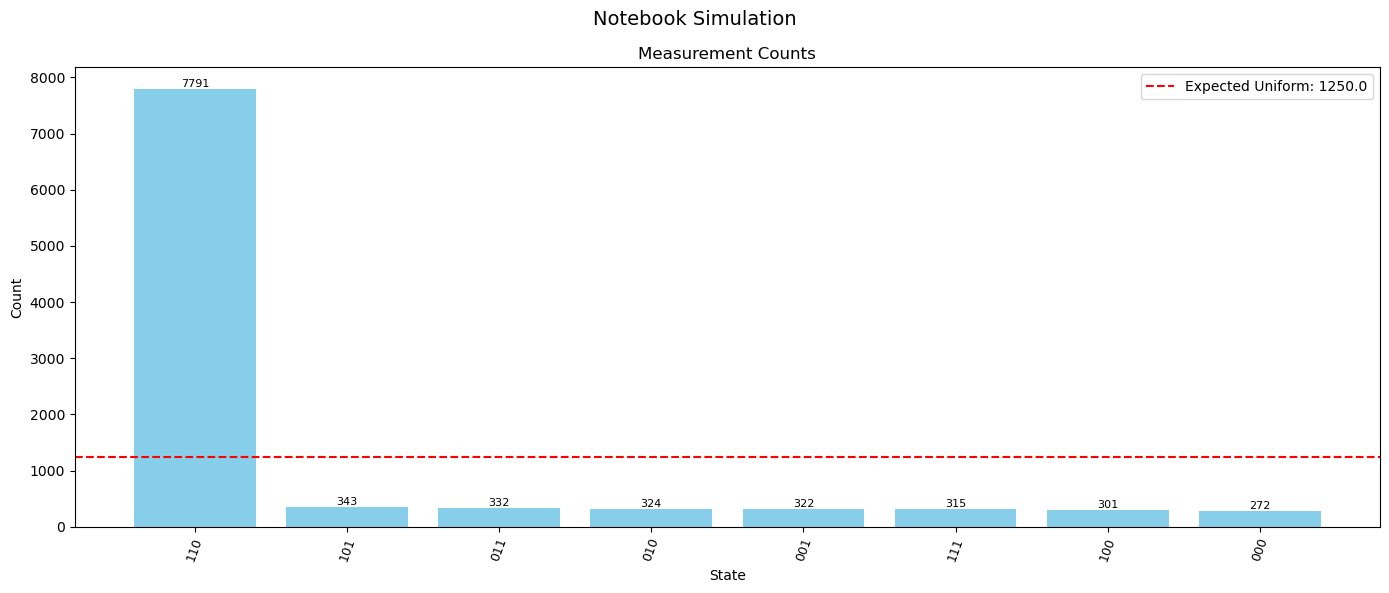

Total samples: 10000
Highest state: 110 (7791 counts, 77.91%)
Lowest state: 000 (272 counts, 2.72%)
✓ Strong signal detected in state 110 (77.9%)


{'total_samples': 10000, 'top_state': '110', 'top_probability': 0.7791}

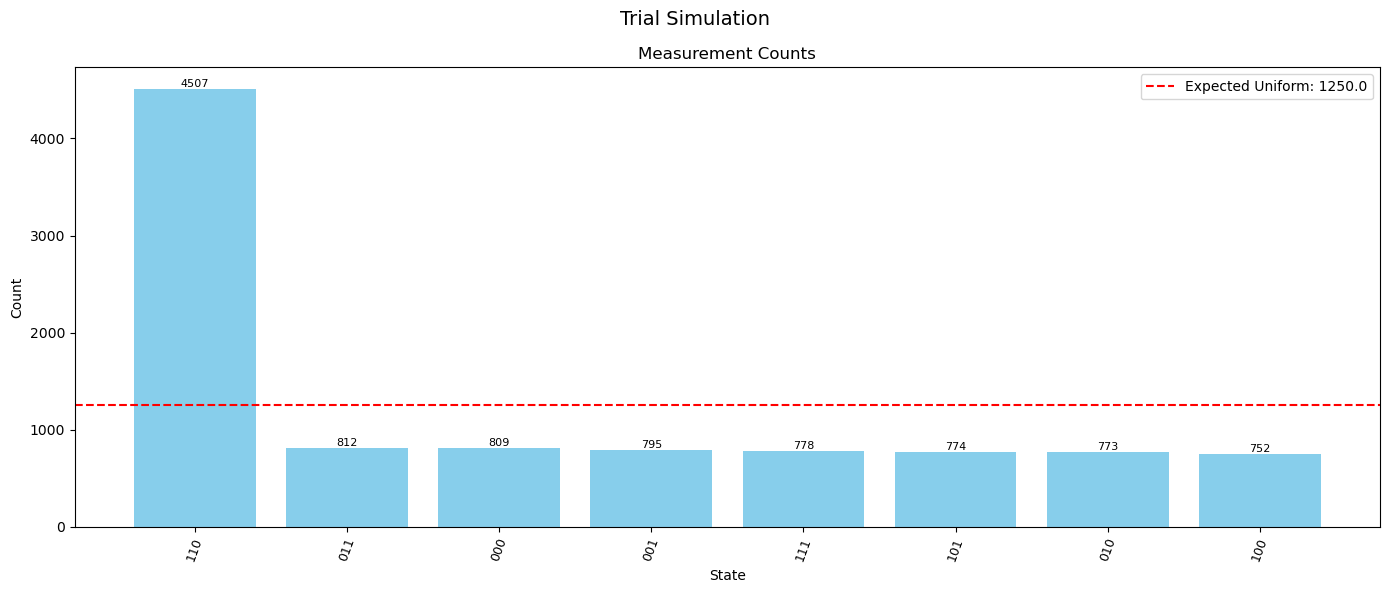

Total samples: 10000
Highest state: 110 (4507 counts, 45.07%)
Lowest state: 100 (752 counts, 7.52%)
✓ Strong signal detected in state 110 (45.1%)


{'total_samples': 10000, 'top_state': '110', 'top_probability': 0.4507}

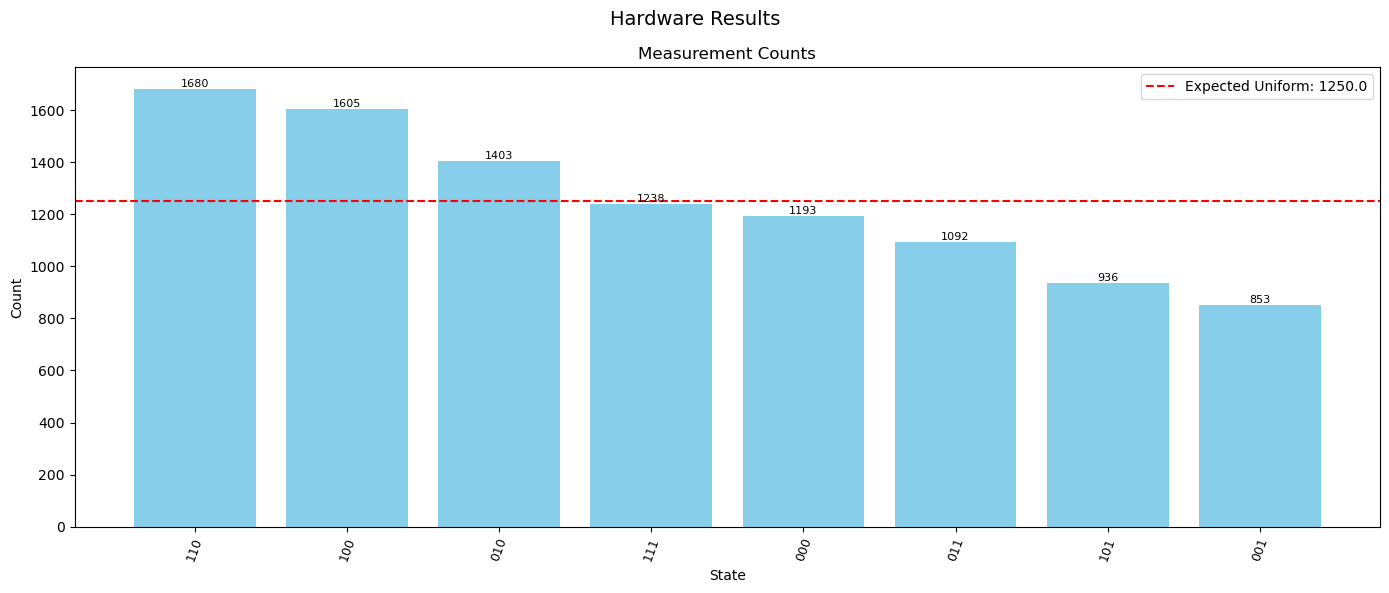

Total samples: 10000
Highest state: 110 (1680 counts, 16.80%)
Lowest state: 001 (853 counts, 8.53%)
⚠ No clear winner detected. Top state has only 16.8% probability
⚠ Distribution appears close to uniform (max variation: 4.3%)


{'total_samples': 10000, 'top_state': '110', 'top_probability': 0.168}

KeyError: '010000111'

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def simple_visualize_results(results_dict, title="Quantum Measurement Results"):
    # Basic calculations
    total_samples = sum(results_dict.values())
    n_qubits = len(list(results_dict.keys())[0])
    
    # Sort results by count (descending)
    sorted_results = dict(sorted(results_dict.items(), key=lambda x: x[1], reverse=True))
    
    # Create figure with two subplots
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. Bar chart of states
    bars = ax1.bar(range(len(sorted_results)), sorted_results.values(), color='skyblue')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # Set the x-tick positions and labels
    ax1.set_xticks(range(len(sorted_results)))
    ax1.set_xticklabels(list(sorted_results.keys()), rotation=70, fontsize=9)
    
    # Add uniform expectation line
    expected_uniform = total_samples / len(results_dict)
    ax1.axhline(y=expected_uniform, color='red', linestyle='--', 
                label=f'Expected Uniform: {expected_uniform:.1f}')
    
    ax1.set_title('Measurement Counts')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print simple statistics
    print(f"Total samples: {total_samples}")
    print(f"Highest state: {list(sorted_results.keys())[0]} ({list(sorted_results.values())[0]} counts, {list(sorted_results.values())[0]/total_samples*100:.2f}%)")
    print(f"Lowest state: {list(sorted_results.keys())[-1]} ({list(sorted_results.values())[-1]} counts, {list(sorted_results.values())[-1]/total_samples*100:.2f}%)")
    
    # Check for clear winner (probability > 20%)
    top_prob = list(sorted_results.values())[0] / total_samples
    if top_prob > 0.2:
        print(f"✓ Strong signal detected in state {list(sorted_results.keys())[0]} ({top_prob*100:.1f}%)")
    else:
        print(f"⚠ No clear winner detected. Top state has only {top_prob*100:.1f}% probability")
    
    # Check for uniformity
    uniformity_threshold = 0.05  # 5% variation
    max_variation = max(abs(count/total_samples - 1/len(results_dict)) for count in results_dict.values())
    
    if max_variation < uniformity_threshold:
        print(f"⚠ Distribution appears close to uniform (max variation: {max_variation*100:.1f}%)")
    
    # Return a simple summary for programmatic use
    return {
        "total_samples": total_samples,
        "top_state": list(sorted_results.keys())[0],
        "top_probability": top_prob,
    }

# from this notebook
display(simple_visualize_results(sim_counts, "Notebook Simulation"))

# from the trial
display(simple_visualize_results(trial.simulation_counts, "Trial Simulation"))
display(simple_visualize_results(trial.counts, "Hardware Results"))

## Plot

Analyzing CLIQUE problems:
  Total instances: 9000
  Total trials: 2080
  Completed trials: 2022

(n, grover_iterations) = (3, 1) 	 (26 trials)
Mean success rate: 0.1794
Mean success rate over expected: 0.2297
(n, grover_iterations) = (4, 1) 	 (25 trials)
Mean success rate: 0.1131
Mean success rate over expected: 0.1555
(n, grover_iterations) = (4, 2) 	 (6 trials)
Mean success rate: 0.0618
Mean success rate over expected: 0.0681
(n, grover_iterations) = (6, 1) 	 (32 trials)
Mean success rate: 0.0602
Mean success rate over expected: 0.1266
(n, grover_iterations) = (7, 2) 	 (35 trials)
Mean success rate: 0.0254
Mean success rate over expected: 0.0505
(n, grover_iterations) = (7, 1) 	 (44 trials)
Mean success rate: 0.0411
Mean success rate over expected: 0.1280
(n, grover_iterations) = (7, 3) 	 (23 trials)
Mean success rate: 0.0174
Mean success rate over expected: 0.0283
(n, grover_iterations) = (7, 4) 	 (20 trials)
Mean success rate: 0.0151
Mean success rate over expected: 0.0198
(n, gro

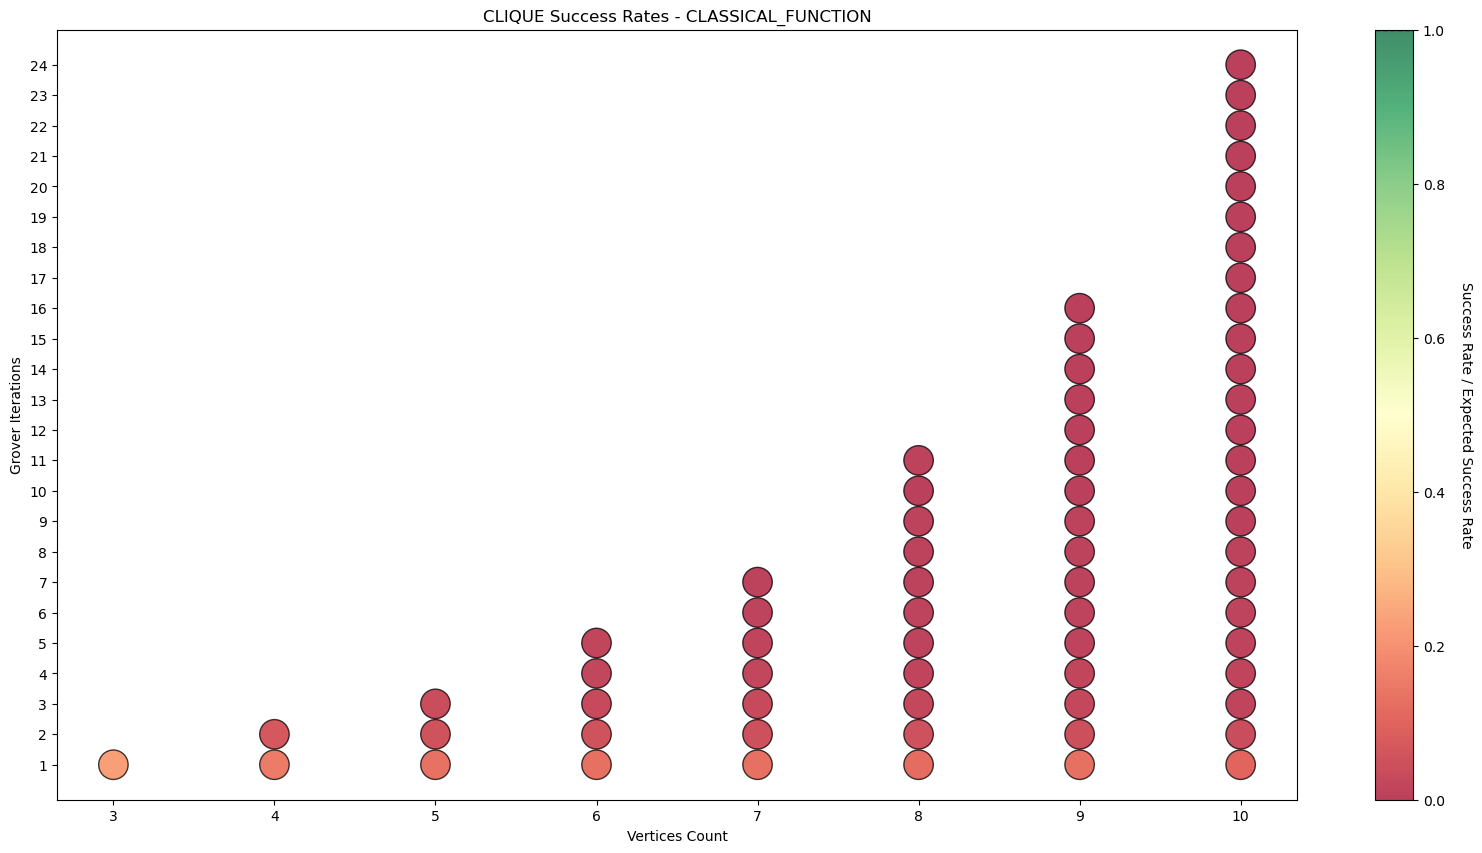

(n, grover_iterations) = (3, 1) 	 (25 trials)
Mean success rate: 0.1584
Mean success rate over expected: 0.2028
(n, grover_iterations) = (4, 2) 	 (7 trials)
Mean success rate: 0.0638
Mean success rate over expected: 0.0702
(n, grover_iterations) = (4, 1) 	 (26 trials)
Mean success rate: 0.1057
Mean success rate over expected: 0.1516
(n, grover_iterations) = (7, 3) 	 (24 trials)
Mean success rate: 0.0161
Mean success rate over expected: 0.0264
(n, grover_iterations) = (7, 4) 	 (21 trials)
Mean success rate: 0.0132
Mean success rate over expected: 0.0173
(n, grover_iterations) = (7, 5) 	 (17 trials)
Mean success rate: 0.0123
Mean success rate over expected: 0.0144
(n, grover_iterations) = (7, 6) 	 (8 trials)
Mean success rate: 0.0080
Mean success rate over expected: 0.0096
(n, grover_iterations) = (7, 7) 	 (8 trials)
Mean success rate: 0.0075
Mean success rate over expected: 0.0080
(n, grover_iterations) = (7, 1) 	 (44 trials)
Mean success rate: 0.0408
Mean success rate over expected: 0.

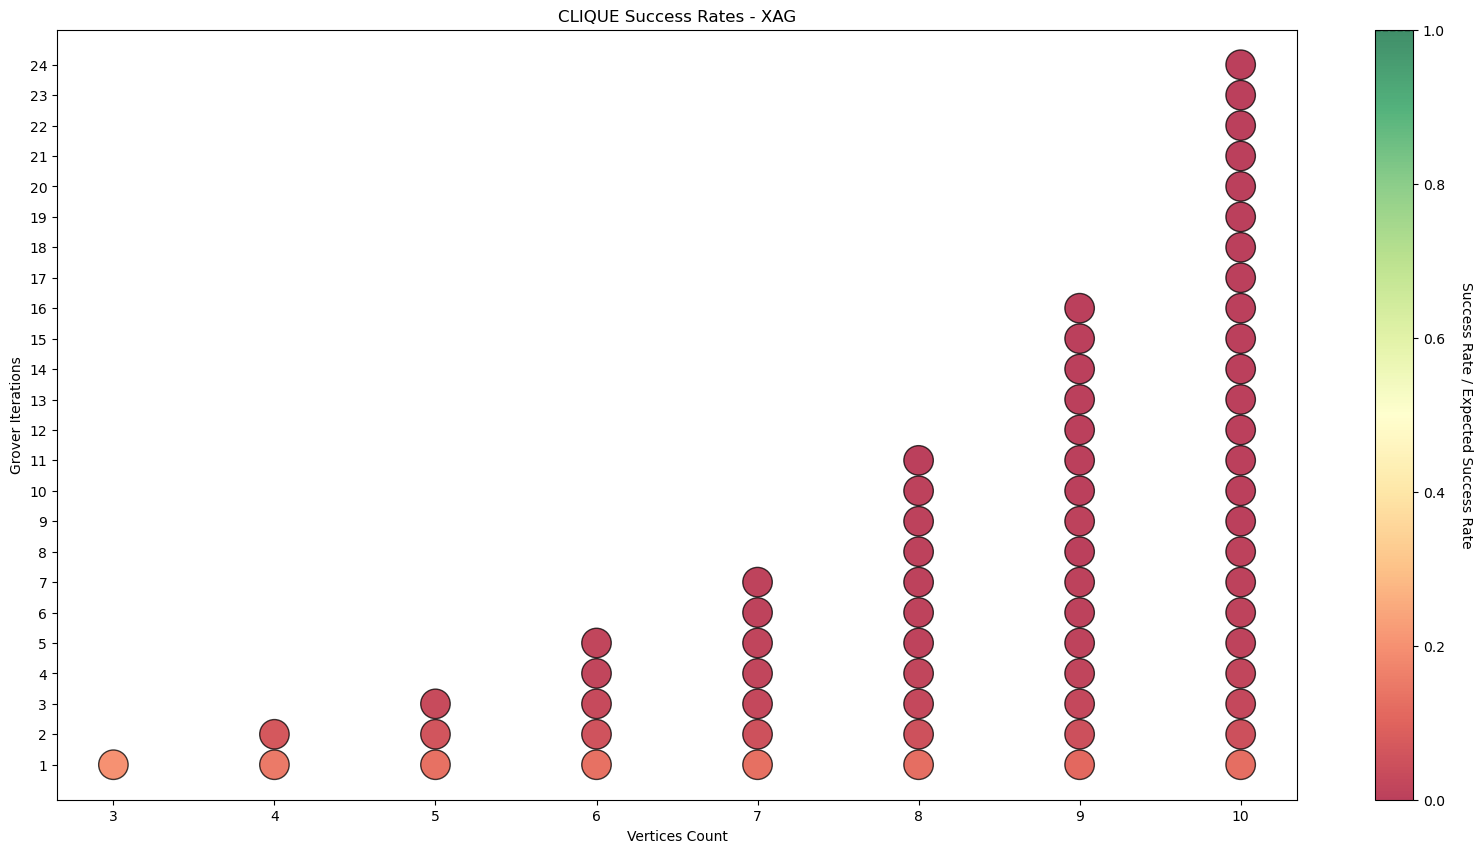

In [4]:
from benchmarklib.analysis import analyze_success_rates

save_dir = "plots"
analyze_success_rates(db, [CompileType.CLASSICAL_FUNCTION, CompileType.XAG], save_dir=save_dir)

Quantum Advantage Analysis for CLIQUE problems:
  Total instances: 9000
  Total trials: 2022
  Completed trials: 2022


=== Analyzing XAG ===
(n, grover_iterations) = (3, 1) 	 (25 trials)
Average P_m: 0.1584
Expected oracle calls (noisy): 6.31
Classical oracle calls: 8.00
Theoretical optimal oracle calls: 2.22
Grover iterations used: 1 (vs optimal: 2.2, ratio: 0.45)
Break-even probability threshold: 0.2777
Quantum advantage: YES

(n, grover_iterations) = (4, 2) 	 (7 trials)
Average P_m: 0.0638
Expected oracle calls (noisy): 31.37
Classical oracle calls: 16.00
Theoretical optimal oracle calls: 3.14
Grover iterations used: 2 (vs optimal: 3.1, ratio: 0.64)
Break-even probability threshold: 0.1963
Quantum advantage: NO

(n, grover_iterations) = (4, 1) 	 (26 trials)
Average P_m: 0.1057
Expected oracle calls (noisy): 9.46
Classical oracle calls: 16.00
Theoretical optimal oracle calls: 3.14
Grover iterations used: 1 (vs optimal: 3.1, ratio: 0.32)
Break-even probability threshold: 0.1963
Quant

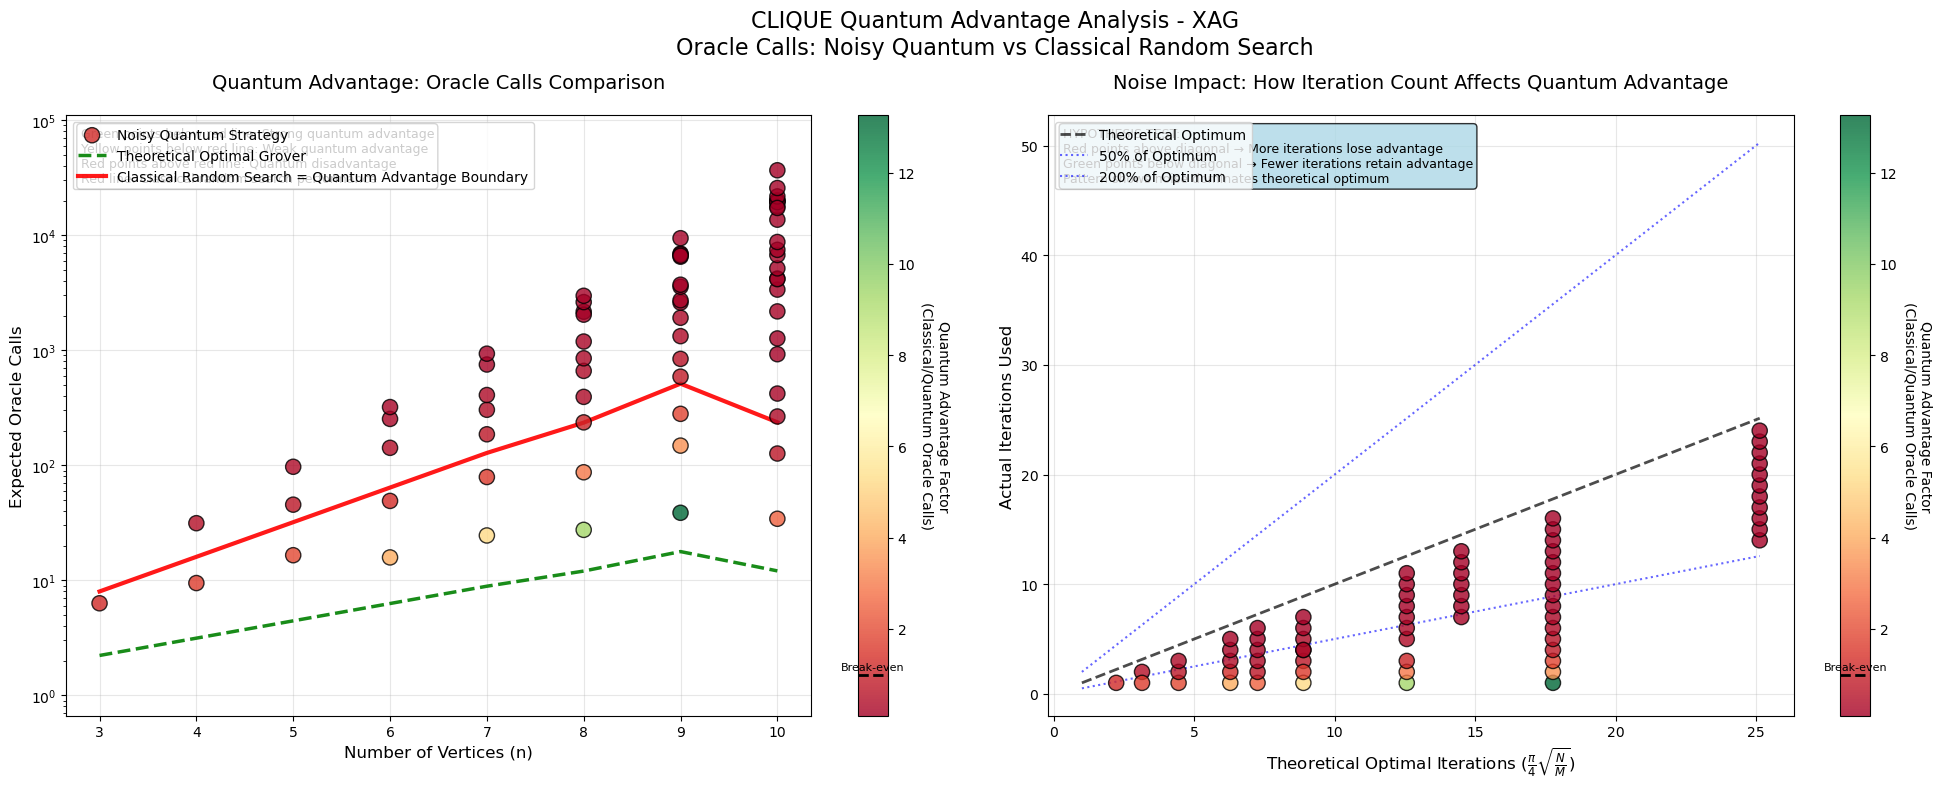


Summary for XAG:
  ✓ Quantum Advantage Analysis:
    - Points with quantum advantage: 14/69 (20.3%)
    - Average success probability: 0.0153
    - Success probability range: 0.0006 - 0.1584
  ✓ Grover Iterations Analysis:
    - Well-optimized iterations (±20%): 10/69 (14.5%)
    - Average iteration ratio (actual/optimal): 0.54
    - Iteration ratio range: 0.06 - 0.95
    - Points losing advantage due to poor iteration choice: 45
      → Consider optimizing Grover iteration counts!

=== Analyzing CLASSICAL_FUNCTION ===
(n, grover_iterations) = (3, 1) 	 (26 trials)
Average P_m: 0.1794
Expected oracle calls (noisy): 5.57
Classical oracle calls: 8.00
Theoretical optimal oracle calls: 2.22
Grover iterations used: 1 (vs optimal: 2.2, ratio: 0.45)
Break-even probability threshold: 0.2777
Quantum advantage: YES

(n, grover_iterations) = (4, 1) 	 (25 trials)
Average P_m: 0.1131
Expected oracle calls (noisy): 8.85
Classical oracle calls: 16.00
Theoretical optimal oracle calls: 3.14
Grover iter

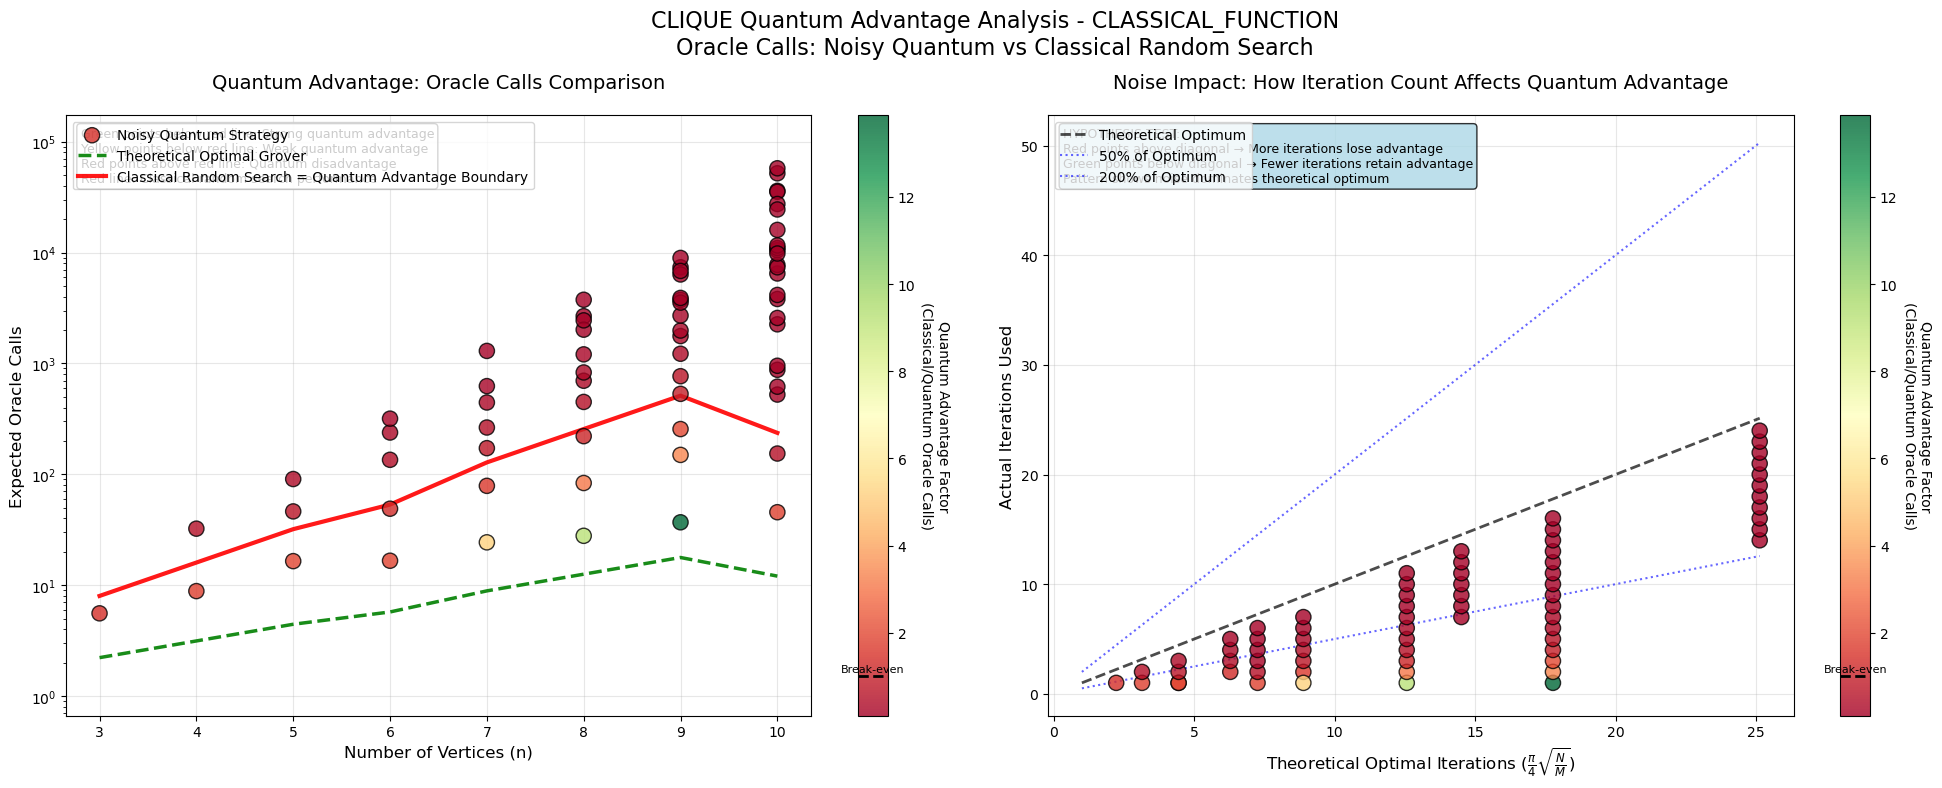


Summary for CLASSICAL_FUNCTION:
  ✓ Quantum Advantage Analysis:
    - Points with quantum advantage: 14/69 (20.3%)
    - Average success probability: 0.0156
    - Success probability range: 0.0004 - 0.1794
  ✓ Grover Iterations Analysis:
    - Well-optimized iterations (±20%): 10/69 (14.5%)
    - Average iteration ratio (actual/optimal): 0.54
    - Iteration ratio range: 0.06 - 0.95
    - Points losing advantage due to poor iteration choice: 45
      → Consider optimizing Grover iteration counts!
(n, grover_iterations) = (3, 1) 	 (25 trials)
Average P_m: 0.1584
Expected oracle calls (noisy): 6.31
Classical oracle calls: 8.00
Theoretical optimal oracle calls: 2.22
Grover iterations used: 1 (vs optimal: 2.2, ratio: 0.45)
Break-even probability threshold: 0.2777
Quantum advantage: YES

(n, grover_iterations) = (4, 2) 	 (7 trials)
Average P_m: 0.0638
Expected oracle calls (noisy): 31.37
Classical oracle calls: 16.00
Theoretical optimal oracle calls: 3.14
Grover iterations used: 2 (vs opti

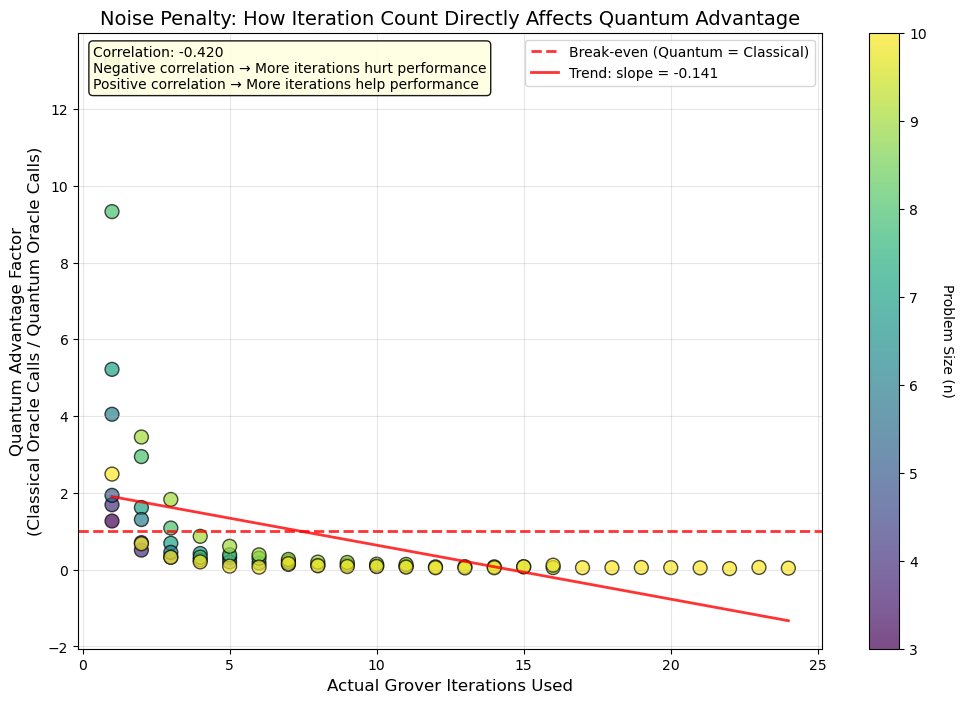

NameError: name 'plot_iteration_efficiency_heatmap' is not defined

In [3]:
from benchmarklib.analysis import *

analyze_quantum_advantage(db, save_dir="./plots")

# Direct correlation test
plot_noise_penalty_analysis(db, CompileType.XAG, "noise_penalty.png")

# 2D landscape view  
plot_iteration_efficiency_heatmap(db, CompileType.XAG, "heatmap.png")

Analyzing quantum advantage for CLIQUE problems:
  Total instances: 9000
  Completed trials: 2022

n=3 bits, k=1 iterations (25 trials)
  Mean quantum advantage factor: 1.27
  Quantum advantage retained
n=4 bits, k=2 iterations (7 trials)
  Mean quantum advantage factor: 0.51
  Quantum advantage lost
n=4 bits, k=1 iterations (26 trials)
  Mean quantum advantage factor: 1.00
  Quantum advantage retained
n=7 bits, k=3 iterations (24 trials)
  Mean quantum advantage factor: 0.32
  Quantum advantage lost
n=7 bits, k=4 iterations (21 trials)
  Mean quantum advantage factor: 0.23
  Quantum advantage lost
n=7 bits, k=5 iterations (17 trials)
  Mean quantum advantage factor: 0.21
  Quantum advantage lost
n=7 bits, k=6 iterations (8 trials)
  Mean quantum advantage factor: 0.17
  Quantum advantage lost
n=7 bits, k=7 iterations (8 trials)
  Mean quantum advantage factor: 0.14
  Quantum advantage lost
n=7 bits, k=1 iterations (44 trials)
  Mean quantum advantage factor: 1.01
  Quantum advantage r

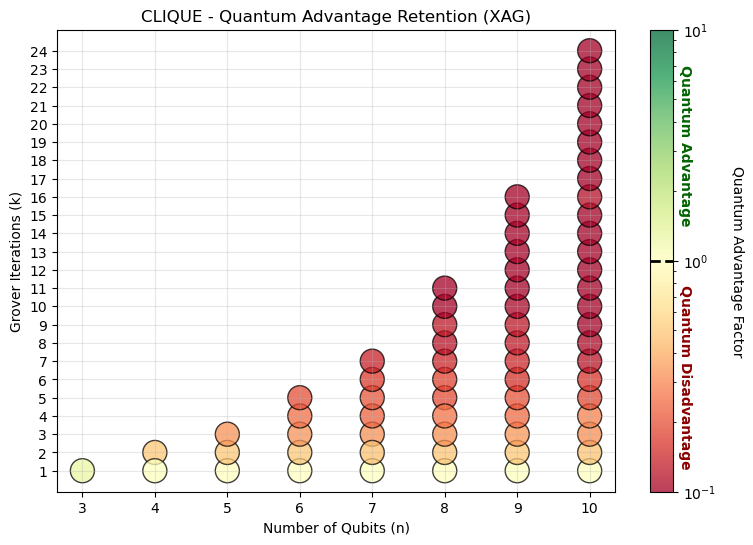

n=3 bits, k=1 iterations (26 trials)
  Mean quantum advantage factor: 1.44
  Quantum advantage retained
n=4 bits, k=1 iterations (25 trials)
  Mean quantum advantage factor: 1.01
  Quantum advantage retained
n=4 bits, k=2 iterations (6 trials)
  Mean quantum advantage factor: 0.49
  Quantum advantage lost
n=6 bits, k=1 iterations (32 trials)
  Mean quantum advantage factor: 0.95
  Quantum advantage lost
n=7 bits, k=2 iterations (35 trials)
  Mean quantum advantage factor: 0.51
  Quantum advantage lost
n=7 bits, k=1 iterations (44 trials)
  Mean quantum advantage factor: 1.03
  Quantum advantage retained
n=7 bits, k=3 iterations (23 trials)
  Mean quantum advantage factor: 0.35
  Quantum advantage lost
n=7 bits, k=4 iterations (20 trials)
  Mean quantum advantage factor: 0.26
  Quantum advantage lost
n=7 bits, k=5 iterations (16 trials)
  Mean quantum advantage factor: 0.18
  Quantum advantage lost
n=7 bits, k=6 iterations (7 trials)
  Mean quantum advantage factor: 0.21
  Quantum advan

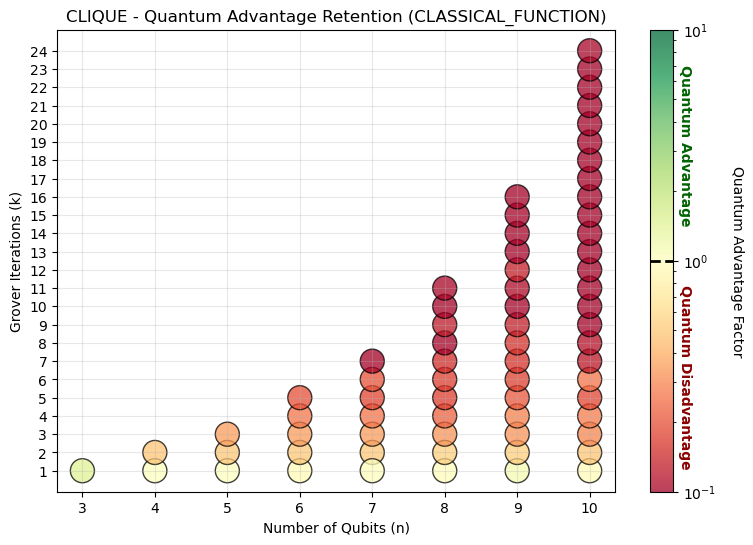

In [4]:
from benchmarklib.analysis import quantum_advantage

quantum_advantage(db, [CompileType.XAG, CompileType.CLASSICAL_FUNCTION], 'plots')